In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd 
import numpy as np
from datetime import datetime 

import csv
import requests

import time
import concurrent.futures

from pairs_selection.api_wrapper import alph_settings as alph, val_steps as val, alph_api_wrapper as wrap

#PCA, Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
%matplotlib inline


In [50]:
settings = alph(
    apikey = "MD27QTTVAK3AJBUQ", 
    site = "https://www.alphavantage.co/query?", 
    date_range = [datetime(2020, 8, 9), datetime(2022, 2, 20)]
    )

In [51]:
tker_dict = val.get_tkers(settings)

In [52]:
valid_lst = val.get_valid_tkers(tker_dict)

In [53]:
test_df = pd.DataFrame(valid_lst)
display(test_df)
test_lst = test_df[0].tolist()
#print(test_lst)

,0,1,2,3,4,5,6
0,VIPS,Vipshop Holdings Ltd,NYSE,Stock,2012-03-23,null,Active
1,YLD,PRINCIPAL ACTIVE HIGH YIELD ETF (FORMERLY PRIN...,NYSE ARCA,ETF,2015-07-09,null,Active
2,GUT-P-C,Gabelli Utility Trust,NYSE,Stock,2016-06-02,null,Active
3,DHF,BNY Mellon High Yield Strategies Fund,NYSE,ETF,1998-04-27,null,Active
4,DK,Delek US Holdings Inc,NYSE,Stock,2006-05-04,null,Active
...,...,...,...,...,...,...,...
8052,GCI,Gannett Co Inc,NYSE,Stock,2014-02-04,null,Active
8053,EMQQ,ETCT EMQQ The Emerging Markets Internet and Ec...,NYSE ARCA,ETF,2014-11-13,null,Active
8054,SLY,SPDR S&P 600 Small Cap ETF,NYSE ARCA,ETF,2005-11-15,null,Active
8055,YELP,Yelp Inc,NYSE,Stock,2012-03-02,null,Active


In [56]:
test_lst

['VIPS',
 'YLD',
 'GUT-P-C',
 'DHF',
 'DK',
 'BBN',
 'VNO',
 'BBEU',
 'MEOH',
 'OXLCN',
 'NTEST-G',
 'DQ',
 'IRTC',
 'HAL',
 'NYT',
 'OVBC',
 'SCHN',
 'LSTA',
 'DXGE',
 'CSTM',
 'MKC',
 'ASTI',
 'HOLI',
 'FRHC',
 'IRM',
 'CEAD',
 'CULL',
 'SBS',
 'APLE',
 'MBINP',
 'OSCV',
 'SR',
 'GNRC',
 'HAFC',
 'MTA',
 'IXP',
 'MTB',
 'AWH',
 'LOPE',
 'ORA',
 'TEF',
 'VDC',
 'NETI',
 'ILCB',
 'PSA-P-L',
 'FFTY',
 'JHS',
 'WMC',
 'ETJ',
 'JOE',
 'RRD',
 'KBE',
 'HRL',
 'USOI',
 'ZIG',
 'VALQ',
 'AN',
 'GBX',
 'FRBA',
 'AVEO',
 'GLIF',
 'ARCE',
 'IHD',
 'PAYX',
 'CLH',
 'EGF',
 'KXI',
 'ALTY',
 'LPTX',
 'GSL-P-B',
 'HEWJ',
 'LEN',
 'CPF',
 'BJ',
 'SRLN',
 'HES',
 'STLV',
 'LOW',
 'CRON',
 'ATLO',
 'PBD',
 'BIGC',
 'GCTK',
 'RINF',
 'GRIL',
 'AKU',
 'VAW',
 'CPG',
 'FMO',
 'LEXX',
 'SAIA',
 'DE',
 'JPM-P-C',
 'AEVA-WS',
 'PCB',
 'CGC',
 'SY',
 'LDUR',
 'X',
 'STPZ',
 'DBEU',
 'EIGR',
 'HFXI',
 'JXJT',
 'LTRPB',
 'RPT-P-D',
 'BRG',
 'SMFG',
 'TCDA',
 'PLW',
 'HIW',
 'PEI-P-B',
 'KHC',
 'LQDA',
 'BKT',


In [57]:
function = "TIME_SERIES_INTRADAY_EXTENDED"
ticker_lst = test_lst[:100]
interval = "60min"
slice = ["year1month1"] #[f"year1month{i}" for i in range(1, 4)] #first three months of intraday data
outputsize = "compact"
test_urls = wrap.intraday_url(settings, function, ticker_lst, interval, outputsize = outputsize, output = "lst")

s = time.time()

with concurrent.futures.ThreadPoolExecutor() as executor: 
    futures = []
    data = []
    for url in test_urls: 
        futures.append(executor.submit(wrap.get_csv_data, url = url))
    for future in concurrent.futures.as_completed(futures): 
        data.append(future.result())

e = time.time()
print(f'Total time elapsed: {e-s} seconds')

# s = time.time()
# result2 = []
# for i in test_urls: 
#     result2.append(wrap.get_csv_data(i))
# e = time.time()
# print(f'Total time elapsed: {e-s} seconds')

Total time elapsed: 15.4781174659729 seconds


In [58]:
print(test_urls[0])
print(len(data[4]))

https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=VIPS&interval=60min&outputsize=compact&adjusted=False&datatype=csv&apikey=MD27QTTVAK3AJBUQ
51



# Clustering

### From PCA, get df

In [78]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# price_data = pd.read_csv(r'C:\Users\Nick\Desktop\Y5S1\IS460 ML\Project\price_pca.csv')
# price_df = price_data.set_index("0")

# x = price_df
# x = StandardScaler().fit_transform(x)
# #print(x)

# pca = PCA(n_components=50)
# principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents, columns = [f"price_component_{i}" for i in range(0, 50)],index=price_df.index)
# display(principalDf)

In [152]:
Xx=pd.read_csv('C:/Users/Nick/Desktop/Y5S1/IS460 ML/Project/price_components.csv').set_index('0')
#X=principalDf

In [154]:
X=preprocessing.StandardScaler().fit_transform(Xx)

In [80]:
check=pd.read_csv('C:/Users/Nick/Desktop/Y5S1/IS460 ML/Project/price_pca.csv')

In [105]:
#Check dimensions of PCA'ed df
print(X.shape)

(1467, 50)


In [82]:
check['0']

0        UAN
1        NPO
2        PWR
3         MX
4        DAN
        ... 
1462    AGRO
1463     PEN
1464     ENB
1465     GWW
1466     MEI
Name: 0, Length: 1467, dtype: object

In [83]:
#Get the ticker names from their index
tick_dic={}
for i,v in enumerate(check['0']):
    tick_dic[i]=v

In [155]:
#Drop NAs and check shape
X=X.dropna()
X.shape

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [115]:
#Unnamed: 0 was just the numeric index
#X.drop(['Unnamed: 0'],axis=1,inplace=True)

In [166]:
Xx.head()

,price_component_0,price_component_1,price_component_2,price_component_3,price_component_4,price_component_5,price_component_6,price_component_7,price_component_8,price_component_9,...,price_component_40,price_component_41,price_component_42,price_component_43,price_component_44,price_component_45,price_component_46,price_component_47,price_component_48,price_component_49
0,,,,,,,,,,,,,,,,,,,,,
UAN,0.362203,0.031611,0.039981,-0.151217,0.032913,-0.089973,0.032174,-0.010064,-0.009712,-0.247576,...,0.024489,0.008714,0.078846,-0.026758,0.048839,0.036223,-0.082635,0.037619,0.021923,-0.145077
NPO,0.081570,0.068504,-0.118898,0.117209,-0.070326,0.108953,-0.193787,-0.057691,-0.033046,0.014115,...,-0.005325,-0.034688,0.009935,0.017283,0.010116,-0.013040,0.009680,-0.057445,-0.011393,-0.001420
PWR,-0.036651,-0.074379,-0.069951,0.112895,0.007161,0.003710,-0.095307,-0.055836,0.010240,0.026082,...,0.034301,-0.035508,0.042381,0.004963,0.050593,0.024630,0.018756,0.003524,0.016714,0.001997
MX,-0.083783,-0.120084,-0.034109,0.096190,0.237727,-0.076279,-0.026769,-0.012442,-0.013492,-0.094570,...,0.034190,0.053912,-0.021635,-0.130686,0.055485,-0.012927,0.064729,-0.081564,0.041890,0.080773
DAN,0.408147,0.270243,-0.219409,0.098361,0.106962,-0.003546,-0.166975,-0.028469,0.090929,-0.081831,...,0.062991,-0.102305,-0.035046,0.056757,0.003092,-0.054314,0.044493,0.025850,-0.076058,-0.035142


In [167]:
#min samples should be 2*data dimension
#Epsilon can be: https://www.section.io/engineering-education/dbscan-clustering-in-python/#:~:text=DBSCAN%20is%20a%20popular%20density,number%20of%20clusters%20required%20prior.

#Clustering using density-based spatial clustering method
#eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
#min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
dbs=DBSCAN(eps=1.5,min_samples=3,n_jobs=1)
print(dbs)

DBSCAN(eps=1.5, min_samples=3, n_jobs=1)


In [168]:
#Noisy samples are given label -1
dbs.fit(X)
labels=dbs.labels_
#n_cl is the number of clusters, excluding -1 cluster because it is for noisy samples
n_cl=len(set(labels)) - (1 if -1 in labels else 0)
print(f'{n_cl} clusters')

10 clusters


In [169]:
cl_lab=dbs.labels_
#cl_series creates a pd series with tickers as index and the cluster label as values
cl_series=pd.Series(index=Xx.index,data=cl_lab.flatten())
#cl_series_2 excludes cluster 1
cl_series_2=cl_series[cl_series!=1]

In [170]:
#cnt is number of tickers within each cluster
#tick_cnt filters out clusters where there is only 1 ticker, or when there is more than 100 tickers
cnt=cl_series_2.value_counts()
tick_cnt=cnt[(cnt>1)&(cnt<=100)]
print(f"Clusters formed: {len(tick_cnt)}")


Clusters formed: 9


In [171]:
#Retrieve clusters 
cl_lst=list(cnt[(cnt < 500) & (cnt > 1)].index)[::-1]

In [162]:
#Plotting multidimensional to 2D
#Check this
X_tsne=TSNE(learning_rate=1000,perplexity=25).fit_transform(Xx)

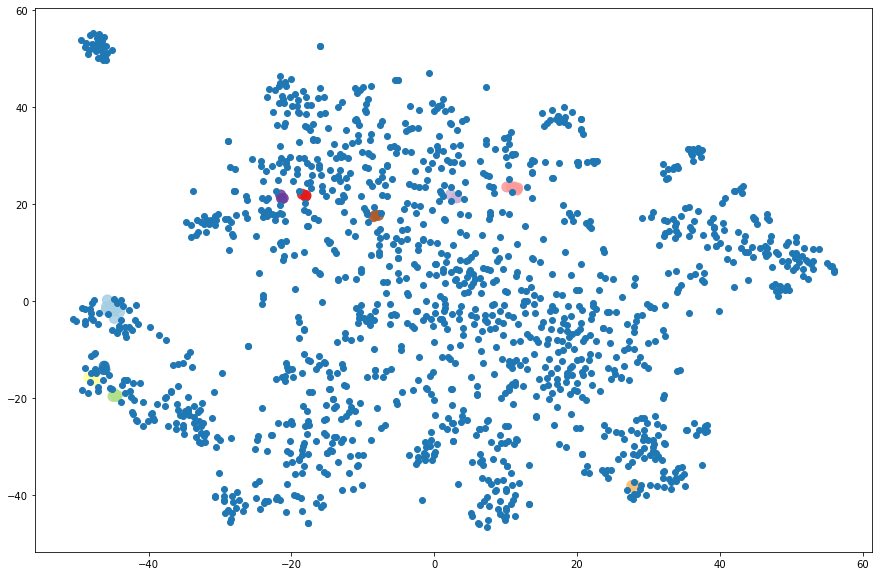

In [172]:
#Plotting the clustered data points
plt.figure(1, facecolor = 'white', figsize = (15, 10))
plt.clf()
#plt.axis('off')
plt.scatter(X_tsne[(labels!=-1), 0], X_tsne[(labels!=-1), 1], s = 100, alpha = 0.85, c = labels[labels!=-1], cmap = cm.Paired)
plt.scatter(X_tsne[(cl_series==-1).values, 0], X_tsne[(cl_series==-1).values, 1])

<BarContainer object of 11 artists>

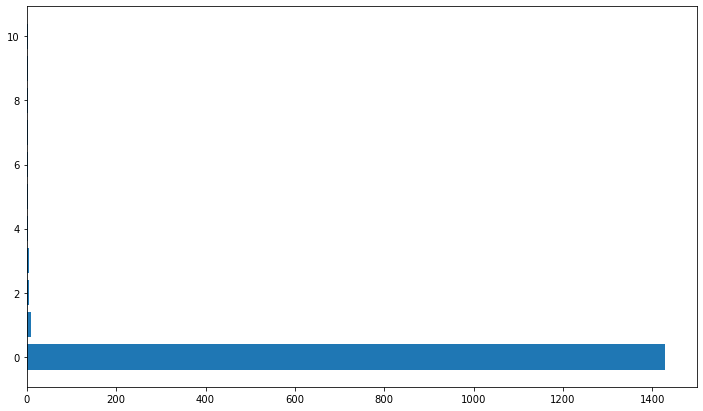

In [173]:
plt.figure(figsize = (12, 7))
plt.barh(range(len(cl_series.value_counts())), cl_series.value_counts())

# Cointegration

In [23]:
def Cointn(cl, sf, Price):
    '''

    This function will retrieve the cointegration results for all combinations of pairs in a cluster.
    Pairs that have p-value <0.05 will be considered cointegrated and appended to pair_coin
    
    '''
    pair_coin = []
    p_value = []
    check=0
    n = cl.shape[0]
    keys = cl.keys()
    for i in range(n):
        for j in range(i+1,n):
            asset_1 = Price.loc[keys[i]]
            asset_2 = Price.loc[keys[j]]
            results = sm.OLS(asset_1, asset_2).fit()
            predict = results.predict(asset_2)
            error = asset_1 - predict
            ADFtest = ts.adfuller(error)
            if ADFtest[1] < sf:
            # coint=CointAnalysis()
            # xx=np.stack([asset_1,asset_2],axis=1)
            # test =  coint.test(xx).pvalue_
            # if test < sf:
                pair_coin.append([keys[i], keys[j]])
                p_value.append(ADFtest[1])
                #p_value.append(test)
    return p_value, pair_coin

In [24]:
import heapq
import operator
def PairSelection(cl_series, sf, Price, E_selection = False):
    '''
    This function runs cointn function for all clusters
    It will then retrieve the ticker name pairs
    '''
    Opt_pairs = [] 
    
    if E_selection == True:
        for i in cl_lst:
            cluster = cl_series[cl_series == i]
            keys = cluster.keys()
            result = Cointn(cluster, sf, Price)
            if len(result[0]) > 0:
                if np.min(result[0]) < sf:
                    index = np.where(result[0] == np.min(result[0]))[0][0]
                    Opt_pairs.append([result[1][index][0], result[1][index][1]]) 
    else:
        p_value_contval = []
        pairs_contval = []
        for i in cl_lst:
            cluster = cl_series[cl_series == i]
            keys = cluster.keys()
            result = Cointn(cluster, sf, Price)
            if len(result[0]) > 0:
                p_value_contval += result[0]
                pairs_contval += result[1]
        
        Opt_pair_index = heapq.nsmallest(20, range(len(p_value_contval)), key=p_value_contval.__getitem__)
        Opt_pairs = operator.itemgetter(*Opt_pair_index)(pairs_contval)
    return Opt_pairs

In [25]:
sf=0.05
optprs=PairSelection(cl_series,sf,X)

In [26]:
optprs

([580, 583],
 [798, 800],
 [798, 801],
 [799, 800],
 [799, 801],
 [800, 802],
 [800, 806],
 [800, 808],
 [801, 802],
 [801, 805],
 [801, 808],
 [862, 871],
 [863, 872],
 [864, 866],
 [864, 867],
 [864, 870],
 [865, 866],
 [1136, 1140],
 [1119, 1124],
 [1124, 1127])

In [31]:
asset_1 = X.iloc[580]
asset_2 = X.iloc[583]
results = sm.OLS(asset_1, asset_2).fit()
predict = results.predict(asset_2)
error = asset_1 - predict
ADFtest = ts.adfuller(error)

In [34]:
from cointanalysis import CointAnalysis
from pandas_datareader.data import DataReader

0.0

In [37]:
coint=CointAnalysis()
xx=np.stack([asset_1,asset_2],axis=1)
test =  coint.test(xx).pvalue_


array([[ 5.80000000e+02,  5.83000000e+02],
       [-1.07296155e+00, -1.21272861e+00],
       [-8.94763918e-03, -4.65844775e-02],
       [ 7.90091230e-03, -2.49631497e-03],
       [-2.68941116e-03,  1.50053083e-03],
       [-7.66633869e-03,  3.33927639e-03],
       [-4.10823150e-03, -7.63036713e-04],
       [-1.67115753e-03,  7.22509289e-04],
       [-2.43107132e-03, -2.61913901e-04],
       [-5.90077582e-04,  3.90466682e-04],
       [-3.51357018e-03, -5.62171056e-04],
       [-1.57726531e-03,  4.29172474e-04],
       [-3.43415203e-03,  1.34270779e-04],
       [-8.94046992e-04,  8.26251221e-04],
       [-2.70348279e-03, -1.55598182e-03],
       [-1.53467191e-03,  2.62957906e-03],
       [-1.94108465e-03,  3.33447649e-03],
       [ 2.47578085e-03,  2.49825046e-03],
       [-2.61685871e-03,  1.17319433e-03],
       [ 2.55867585e-03,  3.21588509e-04],
       [ 8.95474342e-04, -2.93673637e-03],
       [-1.56101425e-03, -3.05529793e-03],
       [ 3.84580074e-04,  7.31700115e-04],
       [-7.

In [43]:
#fetch function
def fetch_stocks(ticker):
    return DataReader(ticker,'yahoo','2020-08-09','2022-02-20')['Adj Close']

In [44]:
s1=fetch_stocks('DCI')
s2=fetch_stocks('OII')

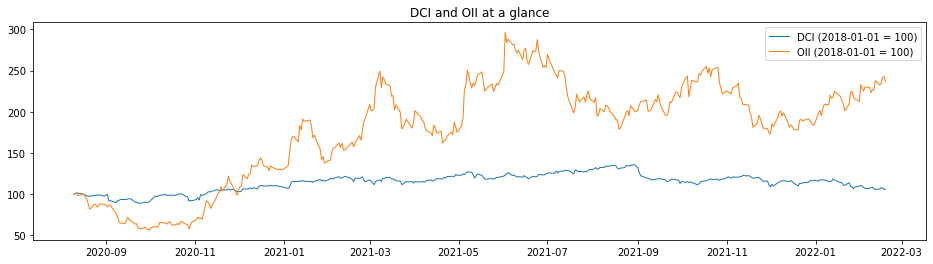

In [45]:
plt.figure(figsize=(16, 4))

plt.title('DCI and OII at a glance')
dci_perc = 100 * s1 / s1[0]
oii_perc = 100 * s2 / s2[0]
plt.plot(dci_perc, label='DCI (2018-01-01 = 100)', linewidth=1)
plt.plot(oii_perc, label='OII (2018-01-01 = 100)', linewidth=1)

plt.legend()

In [46]:
coint = CointAnalysis()

test_coin = np.stack([s1, s2], axis=1)

coint.test(test_coin).pvalue_

0.5076559374368161

In [27]:
prs=[]
for i in optprs:
    s1=tick_dic.get(i[0])
    s2=tick_dic.get(i[1])
    prs.append([s1,s2])
    

In [28]:
prs

[['DCI', 'OII'],
 ['BBVA', 'BDX'],
 ['BBVA', 'AME'],
 ['RC', 'BDX'],
 ['RC', 'AME'],
 ['BDX', 'PBT'],
 ['BDX', 'CNP'],
 ['BDX', 'TU'],
 ['AME', 'PBT'],
 ['AME', 'HTGC'],
 ['AME', 'TU'],
 ['AUD', 'GCP'],
 ['PNM', 'NGL'],
 ['HP', 'CLF'],
 ['HP', 'SB'],
 ['HP', 'SHLX'],
 ['CLR', 'CLF'],
 ['ICE', 'CB'],
 ['OHI', 'CIG'],
 ['CIG', 'PBR-A']]

In [89]:
stck_df=pd.DataFrame(prs,columns=['Stock 1','Stock 2'])
# stck_df.to_csv('stck_df.csv')

Rachel method

In [35]:
from cointanalysis import CointAnalysis
from pandas_datareader.data import DataReader

In [ ]:
sf=0.05
#i refers to cluster
i=0
cl_stocks=cl_series_2[cl_series_2==i]
cl_key=cl_stocks.keys()
n=cl_stocks.shape[0]
pair_coin = []
p_value = []
for i in range(n):
    for j in range(i+1,n):
        asset_1 = X.loc[cl_key[i]]
        asset_2 = X.loc[cl_key[j]]
        coint=CointAnalysis()
        xx=np.stack([asset_1,asset_2],axis=1)
        test =  coint.test(xx).pvalue_
        if test < sf:
            pair_coin.append([cl_key[i], cl_key[j]])
            p_value.append(test)

p_value_contval = []
pairs_contval = []
for i in cl_lst:
    if len(p_value) > 0:
        p_value_contval += p_value
        pairs_contval += pair_coin

Opt_pair_index = heapq.nsmallest(20, range(len(p_value_contval)), key=p_value_contval.__getitem__)
Opt_pairs = operator.itemgetter(*Opt_pair_index)(pairs_contval)
